# PREDICTION DE PRIX AIRBNB

*Airbnb est une place de marché en ligne qui permet d'organiser ou d'offrir un hébergement, principalement chez l'habitant, ou des expériences touristiques depuis 2008.*

Le but de ce Notebook est de prédire le logarithme du prix du airbnb pour cela nous avons 2 fichier .csv qui contiennent des informations brut sur le logement (le type de logement, les équipement, la ville dans laquelle se trouve le logement etc...)


## 1) Importation des différentes librairies

Dans le cadre de notre analyse de données nous importerons les librairies :
- panda et numpy (nous permettant de manipuler et effectuer des calcul numérique sur nos données)
  
- seaborn et matplotlib.pyplot (nous permettant de mieux visualiser les données avec des graphique et des matrice
  
- collections.Counter, nltk.corpus.stopwords et nltk (nous permettant d'utiliser des bibliotèque de mots)
  
- sklearn.preprocessing.LabelEncoder et sklearn.feature_extraction.text.TfidfVectorizer (nous permettant d'utiliser de convertir nos données de manière à ce que celles-ci soit utilisables pour un algorithme de machine learning)

- pycaret.regression nous permettra de choisir le meilleur modèle de régression linéaire
  
- sklearn.preprocessing.StandardScaler et sklearn.decomposition.PCA (nous permettant de pouvoir effectuer l'analyse en composante principale sur nos données)
  
- sklearn.model_selection.train_test_split, sklearn.linear_model.LinearRegression, lightgbm.lgbm et sklearn.linear_model.BayesianRidge (nous permttant de pouvoir entrainer un modèle de régression linéaire puis d'évaluer leur perfomance avec sklearn.metrics.mean_squared_error et sklearn.metrics.r2_score)

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import plotly.express as ex

from pycaret.regression import setup, compare_models, finalize_model, predict_model

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error, r2_score

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\33631\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


ModuleNotFoundError: No module named 'pycaret'

## 2) Le chargement des données

On charge les deux fichier .csv pour pouvoir les utiliser par la suite dans notre notebook puis on fait un première affichage de leur contenu.

In [3]:
df_train = pd.read_csv("airbnb_train.csv")
df_test = pd.read_csv("airbnb_test.csv")
df_train.head(10)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10) 
print(df_train)

FileNotFoundError: [Errno 2] No such file or directory: 'airbnb_train.csv'

## 3) Prétraitement des données

Pour continuer a examiner le contenu on regarde le nombre de donnée manquante en fonction des différentes colonnes de la dataframe train.

**1) GESTION DES VALEURS MANQUANTES**

**Il nous faudra remplir ou effacer ces données de manière pertinente pour avoir le modèle le plus précis possible.**

In [ ]:
#Affichage des données manquantes
print(df_train.isnull().sum().to_string())

- On fera une méthode similaire sur les colonnes bathrooms, bedrooms et beds mais pour les remplacer de manière plus pertinente on calculera la moyenne du nombre d'élément en fonction du type de propriété. Pour cela on fait un premier afiichage des différent type de propriété dans les valeurs null puis à l'aide de deux fonction qu'on appelera par la la suite on inserera ces moyennes dans les valeurs manquantes.

In [2]:
#Affichage des différents type de propriété dans les données manquantes de 3 colonnes : bathrooms, bedrooms, beds
print(df_train[df_train['bathrooms'].isnull()]['property_type'].unique())
print(df_train[df_train['bedrooms'].isnull()]['property_type'].unique())
print(df_train[df_train['beds'].isnull()]['property_type'].unique())

NameError: name 'df_train' is not defined

In [5]:
def valeur_manquante_property_type(df, column, property_type):
        #On filtre les données pour le type de propriété spécifique
        filtrer_data= df[df['property_type']== property_type]
        #On vérifie si la série de données n'est pas vide
        if not filtrer_data.empty:
            #Calcule de la moyenne de la colonne pour la propriété mise en paramètre puis on arrondi à l'entier le plus proche et vérifie si elle est nulle
            mean= filtrer_data[column].mean()
            if pd.notna(mean):  # Vérifie que la moyenne n'est pas NaN
                mean = round(mean)
                #On remplit les valeurs manquantes dans la colonne pour nos valeurs manquantes en utilisant la moyenne calculée avant
                df.loc[df['property_type'] == property_type, column] = df.loc[df['property_type'] == property_type, column].fillna(mean)
    

In [6]:
def remplissage_colonne_choisies(df):
    #On itère sur les colonnes choisies
    for column in ['bathrooms', 'bedrooms', 'beds']:
        #On identifie les indices dans les colonnes pour les valeurs manquantes
        na_id = df[df[column].isnull()].index
        for id in na_id:
            property_type = df.loc[id, 'property_type']
            #On utilise la fonction faites avant
            valeur_manquante_property_type(df, column, property_type)

Les colonnes comme first_review, last_review et host_since sont des dates et les valeurs manquantes sont donc plus compliquées à remplir si on veut garder des données cohérentes. Il en est de même pour le neighbourhood qui est une chaine de caractère.

Regardons si ces colonnes sont corrélées avec le log_price en utilisant des affichages

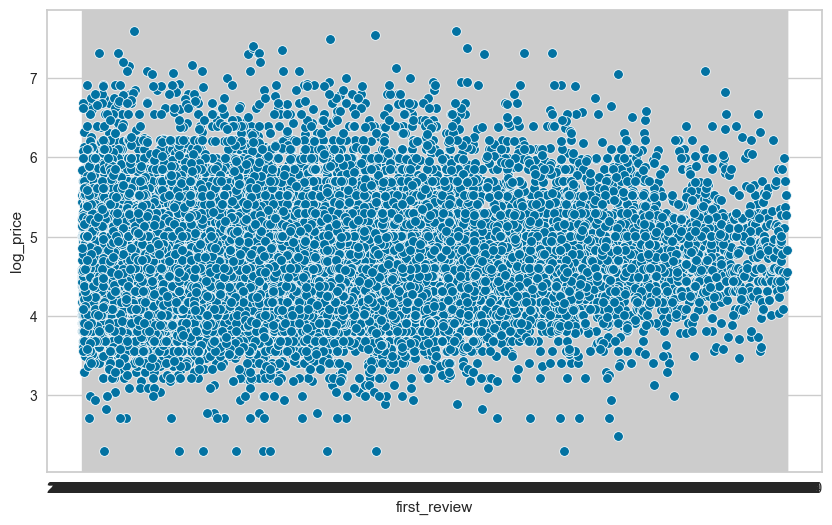

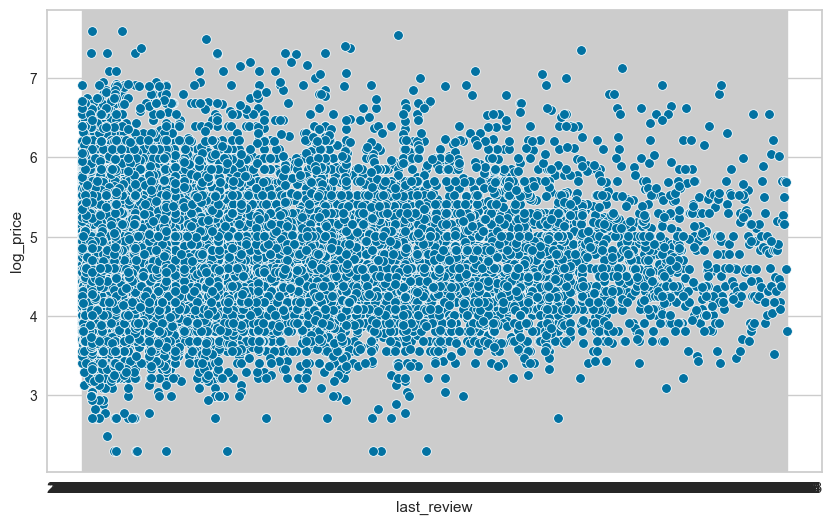

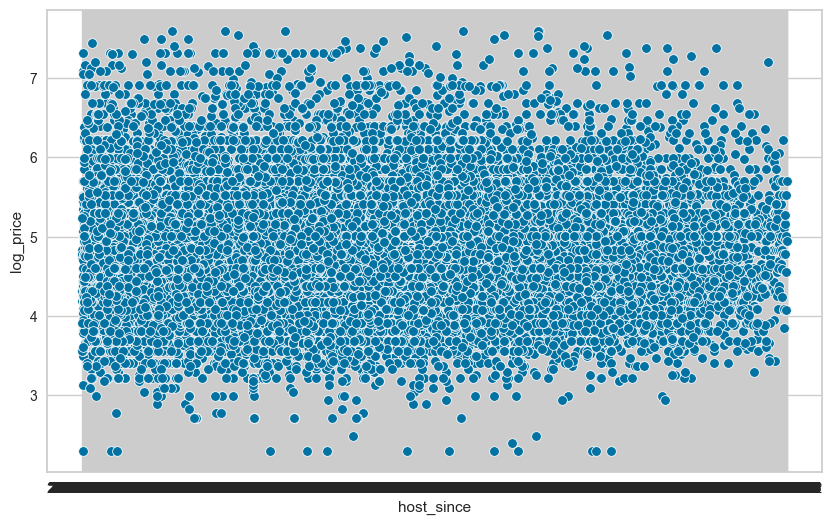

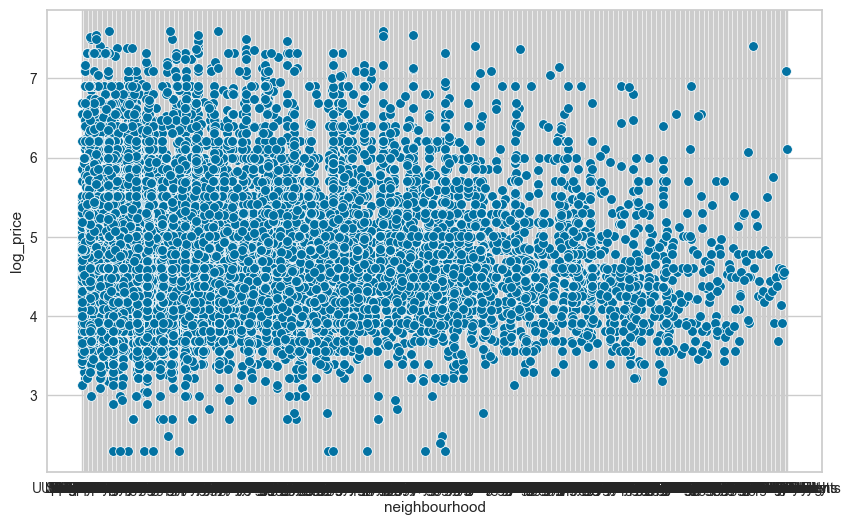

In [7]:
#On visualise la corrélation à l'aide de nuage de point
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_train, x='first_review', y='log_price')
plt.xlabel('first_review')
plt.ylabel('log_price')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_train, x='last_review', y='log_price')
plt.xlabel('last_review')
plt.ylabel('log_price')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_train, x='host_since', y='log_price')
plt.xlabel('host_since')
plt.ylabel('log_price')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_train, x='neighbourhood', y='log_price')
plt.xlabel('neighbourhood')
plt.ylabel('log_price')
plt.show()


**Les graphiques ne montre aucune corrélation entre les colonnes choisies et le log_price on peut expliquer cela notamment du fait que les dates sont très souvent unique de même pour les neighbourhood** 
Cependant vu la part de donner manquante qui est de environ 20% ici nous ne preferons pas garder ces données.
**De plus, on peut enlever la colonne comme id et la colonne zipcode** (on a une colonne city contenant des informations similaire et sans valeur manquante)

**2) ENCODAGE DES VARIABLES CATÉGORIELLES**

Les données de certaines colonnes sont dites sont des variables catégorielles qui ne pourront pas être utiliser par la suite il faut donc convertir nos données de manière à ce que celles-ci soit utilisables pour un algorithme de machine learning.

On va donc encoder nos variables catégorielles avec une librairies qui est LabelEncoder

In [8]:

def encodage_colonnes_choisies(df,colonnes_choisies):
    label_encoder = LabelEncoder()
    #Une valeur de type float est attribuée à toute les variables catégorielles uniques 
    #On remplace les variables catégorielles par le nombre qui leur a été atribué
    for column in colonnes_choisies:
        df[column] = label_encoder.fit_transform(df[column])



**3) UTILISATION DES COLONNES AVEC DES CHAINE DE MOTS**

**On aimerait utiliser les colonnes amenities, description et name qui ont des valeur plutot rare (car étant des chaines de mots) pour être utilisée dans notre algorithme pour cela on va utiliser tfidf pour voir quelles mots sont présent et faire une nouvelle colonne avec les mots qui reviennent le plus.**
On prendra les 100 mots qui reviennent le plus cependant un mot qui est très présent n'est pas forcèment corrélé avec le log_price.

De plus d'un point psychologique il est intéréssant de voir si certain mot dans la description ou le titre sont liés a un prix élevé ou au contraire bas. 
Par exemple est-ce que si des mots du titre sont en rapport avec le luxe le prix sera élevé ?

Par la suite on pourra regarder si certain mot sont corréler avec le prix.

In [9]:

def tfidf_colonne(df, column):
    
    #On initialise pour la colonne et on garde les 100 mots qui reviennent le plus sous la forme de vecteur
    #On définie une liste de mot que l'on ne souhaite pas avoir dans nos mots séléctionnés car ce sont des mots de liaison
    
    tfidf_vecteur= TfidfVectorizer(max_features=500, binary=True,stop_words='english')
    #Transforme le type de la colonne en type str soit une chaine de caractère
    tfidf_matrice= tfidf_vecteur.fit_transform(df[column].astype(str))
    #On récupère les mots obtenus
    mots_recuperation= tfidf_vecteur.get_feature_names_out()
    
    #On créé une nouvelle colonnes pour chaque mot dans un data frame nouveau
    tfidf_df= pd.DataFrame(tfidf_matrice.toarray(),columns=[f'{column}_{mot}' for mot in mots_recuperation])
    #On mets les colonnes obtenue dans la dataframe original
    df= pd.concat([df, tfidf_df], axis=1)
    #On enlève l'ancienne colonne qui ne nous sert plus
    df.drop(columns=[column], inplace=True)
    return df

print(df_train.columns)


Index(['id', 'log_price', 'property_type', 'room_type', 'amenities',
       'accommodates', 'bathrooms', 'bed_type', 'cancellation_policy',
       'cleaning_fee', 'city', 'description', 'first_review',
       'host_has_profile_pic', 'host_identity_verified', 'host_response_rate',
       'host_since', 'instant_bookable', 'last_review', 'latitude',
       'longitude', 'name', 'neighbourhood', 'number_of_reviews',
       'review_scores_rating', 'zipcode', 'bedrooms', 'beds'],
      dtype='object')


**4) FONCTION DE PRETRAITEMENT DES DONNEES**

**On utilise la fonction remplissage_colonne_choisies**

**On remplace toutes les données encore manquantes :**
- Pour les colonnes host_has_profile_pic et host_identity_verified on considère que si la valeur est manquante c'est que le booléen est de valeur fausse donc on remplace par 'f' ici
- Pour review_scores_rating on remplace les valeur manquantes par la moyenne de la colonne
- Pour host_response_rate on a un str avec un % donc on enlève d'abord le pourcentage pour ensuite transformer le str en float.
  Une fois cette étape terminée on calcule la moyenne de la colonne et on remplace dans les valeurs null.

**Création de nouvelle colonne pour les variable catégorielle**
On veut créer de nouvelle colonne qui auront la valeur 0 ou 1 si la ligne
  
**On utilise les fonctions construites avant pour l'encodage et tfidf**

**On drop les colonnes que l'on ne veut plus pour la suite**

En résultat on remarque que nous n'avont plus de valeur null et nous avons uniquement des valeur de type 'float64', 'int64', 'bool'
utilisable lors d'une analyse en composante principale ou pour regarder la corrélation avec le log_price

In [10]:

def preprocess_df(df, train_columns=None):
    remplissage_colonne_choisies(df)
    
    df["host_has_profile_pic"].fillna("f", inplace=True)
    df["host_identity_verified"].fillna("f", inplace=True)
    df["review_scores_rating"].fillna(df["review_scores_rating"].mean(), inplace=True)
    df["host_response_rate"] = df["host_response_rate"].str.rstrip('%').astype(float)
    mean_response_rate = df["host_response_rate"].mean()
    df["host_response_rate"].fillna(mean_response_rate, inplace=True)
    df["host_response_rate"] = df["host_response_rate"].astype(int)
    
    #Colonne de variable catégorielle
    categorielle_col = ['property_type', 'room_type', 'bed_type', 'cancellation_policy', 'city','host_has_profile_pic', 'host_identity_verified', 'instant_bookable']
    df_encoded= pd.get_dummies(df[categorielle_col], prefix=categorielle_col)  
    df = pd.concat([df, df_encoded], axis=1)   

    #On encode les variables catégorielle
    encodage_colonnes_choisies(df,categorielle_col)
    
    # On utilise la fonction tfidf sur les colonnes prédéfinies
    df = tfidf_colonne(df, 'amenities')
    df = tfidf_colonne(df, 'description')
    df = tfidf_colonne(df, 'name')

    df.drop(columns=['first_review', 'last_review', 'host_since', 'neighbourhood', 'zipcode'], inplace=True)

    #On s'assure que toutes les colonnes utilisées pendant l'entraînement sont présentes
    if train_columns is not None:
        missing_cols =set(train_columns) - set(df.columns)
        for col in missing_cols:
            df[col]= 0
        df = df[train_columns]
    return df


## 4) Entrainement d'un modèle pour prédire le log_price

**1) CONSERVATION DES DONNEES QUI ONT LE PLUS DE CORRELATION AVEC LE PRIX**

Après avoir créé plein de données utilisable il faut effectuer un tri en ne gardant que les données qui on une corrélation significative (au dessus d'un seuil définie) avec le log_price.


In [11]:
def correlation_colonne (df_train_processed):
    
    correlations= df_train_processed.select_dtypes(include=['float64', 'int64', 'bool']).corrwith(df_train_processed['log_price']).abs()
    #On trie les corrélations par ordre décroissant
    correlations= correlations.sort_values(ascending=False)
    #On garde les colonnes avec les corrélations les plus élevées ici au dessus de 4% 
    seuil=0.04
    correlated_columns = correlations[correlations >seuil].index
    #On les mets dans df_train_bis une dataframe que l'on utilisera pour entrainer le modèle
    df_train_bis= df_train_processed[correlated_columns]
    #On affiche les 10 colonnes avec le plus de corrélation avec le log_price
    print(correlations.sort_values(ascending=False).head(10))
    #On s'assure que toutes les colonnes utilisées pendant l'entraînement sont présentes
    return df_train_bis, correlated_columns

df_train_processed = preprocess_df(df_train)
df_train_bis, correlated_columns = correlation_colonne(df_train_processed)
#On affiche la nouvelle dataframe
print(df_train_bis)


log_price                    1.000000
room_type                    0.601997
room_type_Entire home/apt    0.597797
accommodates                 0.564874
room_type_Private room       0.526310
bedrooms                     0.472623
beds                         0.434676
bathrooms                    0.368476
name_room                    0.326655
amenities_family             0.228838
dtype: float64
       log_price  room_type  room_type_Entire home/apt  accommodates  \
0       4.317488          1                      False             3   
1       4.007333          1                      False             4   
2       7.090077          0                       True             6   
3       3.555348          1                      False             1   
4       5.480639          0                       True             4   
...          ...        ...                        ...           ...   
22229   4.605170          1                      False             1   
22230   5.043425          0  


**On utilise une matrice de corrélation** entre les différentes colonnes de notre dataframe train. Cela nous permettra d'avoir un affichage simple des relations entre nos données.
Pour garder une matrice compréhensible on réduira volontairement la taille de notre dataframe pour avoir quelque chose de plus lisible.

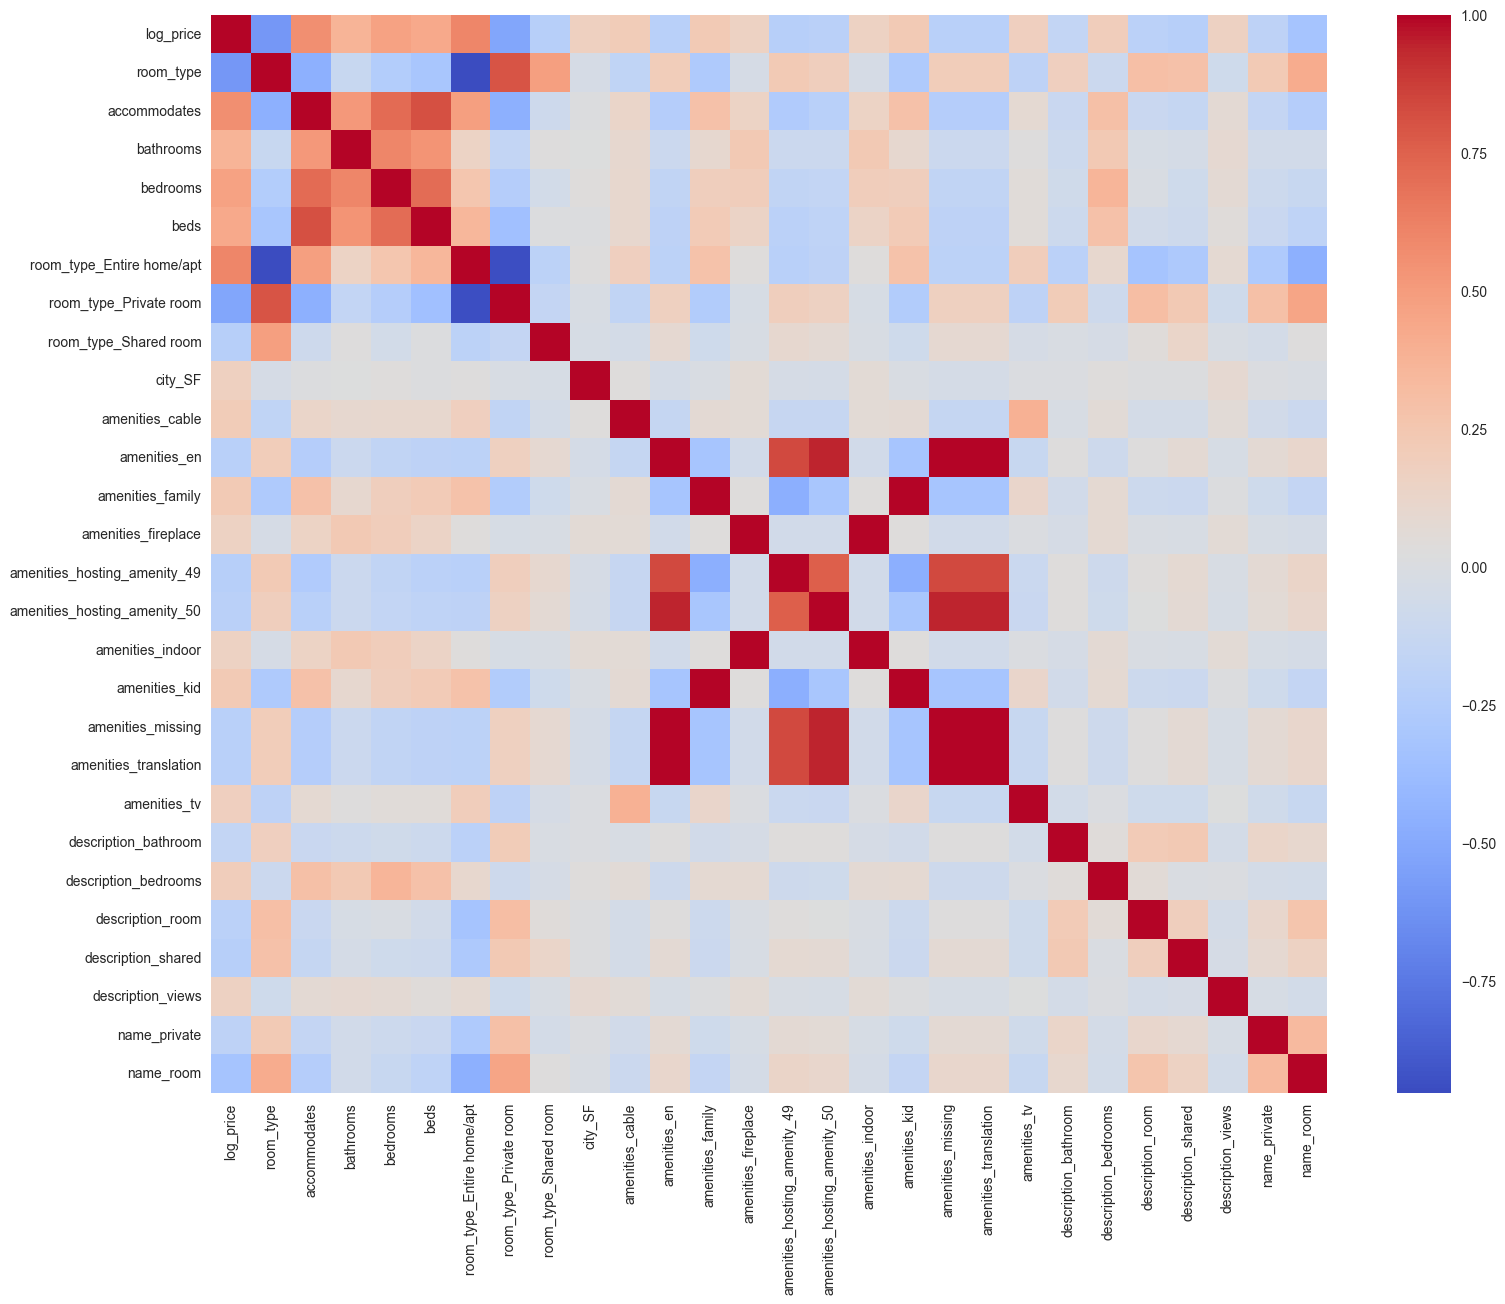

In [12]:
correlations= df_train_processed.select_dtypes(include=['float64', 'int64', 'bool']).corrwith(df_train_processed['log_price']).abs()
correlations_bis= df_train_processed.select_dtypes(include=['float64', 'int64', 'bool']).corrwith(df_train_processed['log_price']).abs()
correlations_bis= correlations.sort_values(ascending=False)
#on augmente le seuil pour prendre moins de colonne et avoir quelque chose de lisible
seuil=0.15
correlated_columns = correlations[correlations >seuil].index
#On les mets dans df_train_3 spécialemént pour faire une matrice de corrélation avec les colonnes les plus corrélée avec le log_price
df_train_3= df_train_processed[correlated_columns]

correlation_matrix = df_train_3.corr(method='pearson', min_periods=1)
non_numeric_cols = correlation_matrix.select_dtypes(exclude=[np.number]).columns
correlation_matrix = correlation_matrix.drop(columns=non_numeric_cols, index=non_numeric_cols)
plt.figure(figsize=(18, 14))
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.show()

**On configure Pycaret pour la régression en utilisant notre data frame modifiée et en spécifiant log_price comme variable cible.** 
On normalise les données et applique la PCA pour réduire la dimensionnalité à 54 composantes principales (qui correspond au nombre maximum de composantes possible).
Pycaret nous permet de comparer automatiquement plusieurs modèles de régression pour identifier le plus performant puis on l'affiche.
Tous ce processus nous permet d'accéler notre phase d'entrainement des données.

**Pour estimer le log_price c'est un problème de régression et non de classification c'est pourquoi on cherche ici un modèle de régression.**

In [13]:
nb=394
exp_reg= setup(data=df_train_bis, target='log_price', session_id=42, normalize=True, pca=True, pca_components=nb)

#On compare les modèles pour regarder les meilleurs
meilleur_modele = compare_models()

#On affiche le meilleur modèle
print(meilleur_modele)

,Description,Value
0,Session id,42
1,Target,log_price
2,Target type,Regression
3,Original data shape,"(22234, 398)"
4,Transformed data shape,"(22234, 395)"
5,Transformed train set shape,"(15563, 395)"
6,Transformed test set shape,"(6671, 395)"
7,Numeric features,375
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lar,Least Angle Regression,0.3137,0.1813,0.4255,0.6496,0.0730,0.0664,0.7530
lr,Linear Regression,0.3140,0.1815,0.4258,0.6491,0.0731,0.0664,1.6420
ridge,Ridge Regression,0.3168,0.1840,0.4287,0.6443,0.0736,0.0671,0.5760
br,Bayesian Ridge,0.3168,0.1841,0.4288,0.6442,0.0736,0.0671,0.7860
huber,Huber Regressor,0.3141,0.1854,0.4302,0.6417,0.0736,0.0661,3.2020
lightgbm,Light Gradient Boosting Machine,0.3255,0.1925,0.4385,0.6279,0.0751,0.0688,3.2160
gbr,Gradient Boosting Regressor,0.3387,0.2059,0.4536,0.6019,0.0778,0.0718,55.1490
omp,Orthogonal Matching Pursuit,0.3394,0.2066,0.4543,0.6007,0.0780,0.0720,0.9660
et,Extra Trees Regressor,0.3407,0.2103,0.4583,0.5935,0.0784,0.0721,40.2620
rf,Random Forest Regressor,0.3431,0.2128,0.4611,0.5887,0.0789,0.0727,135.1970


Lars(random_state=42)


On souhaite rajouter certaines colonne présente de base dans le fichier .csv pour obtenir une meilleur analyse en composante principale et ainsi améliorer notre score de précision par la suite

In [15]:
colonne =['property_type', 'room_type', 'accommodates', 'bathrooms', 'bed_type',
    'cancellation_policy', 'cleaning_fee', 'city', 'host_has_profile_pic',
    'host_identity_verified', 'host_response_rate', 'instant_bookable', 'latitude',
    'longitude', 'number_of_reviews', 'review_scores_rating', 'bedrooms', 'beds']
seuil=0.04
correlated_columns = correlations[correlations >seuil].index
df_train_bis = df_train_processed[list(correlated_columns ) + colonne]

**2) UTILISATION DE L'ACP (ANALYSE EN COMPOSANTES PRINCIPALES)**

**On applique la pca à df_train_bis afin de réduire la dimensionnalité de notre ensemble de données tout en préservant au mieux les informations contenues dans les variables initiales**. Cela nous permettra de visualiser la structure des données dans un espace de dimension réduite ce qui nous facilitera l'interpretation de la corrélations entre celle-ci.
Cela nous permettra aussi d'améliorer les performances de nos modèles en réduisant le surajustement

1) On prend toutes les colonnes de notre dataframe bis sauf celle qui contient le log_price. 
On stockera ces colonnes dans X et la colonne des prix dans y.

In [16]:
X = df_train_bis.drop(columns=['log_price'])
y = df_train_bis['log_price']

2) On ajuste les valeurs de nos caractéristiques pour qu'elles aient une moyenne de 0 et un écart type de 1. Cela rend nos données plus faciles à traiter pour nos algo de machine learning. C'est standard scaler qui nous permet ici de centrer et mettre à l'échelle nos données

In [17]:
# Normalisation des données à l'aide de standard scaler
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

In [18]:
pca = PCA(n_components=394)
#Les données réduites sont stockées dans X_pca
X_pca= pca.fit_transform(X_normalized)

On trace un graphe qui représente la variance expliquée

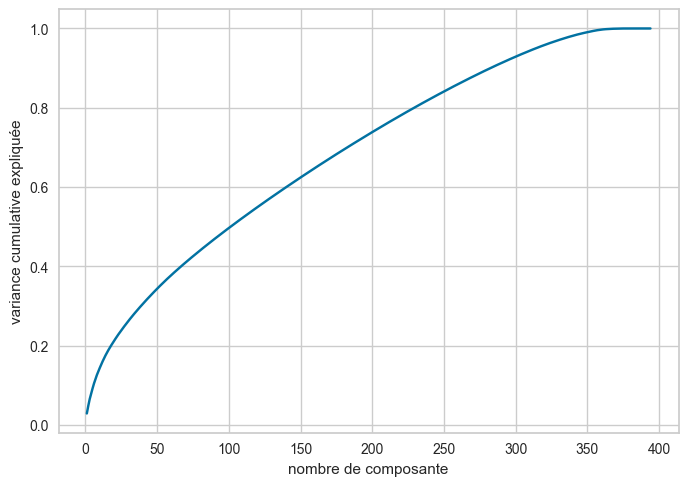

In [19]:
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.plot(range(1, 394+1), explained_variance)
plt.xlabel('nombre de composante')
plt.ylabel('variance cumulative expliquée')
plt.grid(True)
plt.show()

**3) ENTRAINEMENT DE PLUSIEURS MODELE**

Tout d'abord on utilisera un modèle de linear regresion qui a pour avantage d'être facile à implémenter et nécessitant peu de ressources informatiques.
De plus ce modèle à la deuxième position de notre pycaret

Ensuite on utilisera le modele lightgbm qui a obtenu la sixième position lors de notre pycaret. L'avantage de ce modèle réside dans sa capacité à gérer des ensembles de données volumineux avec une grande précision. 
Pour cela il utilise des arbres de décision boostés graduels pour améliorer continuellement les prédictions.
De plus, il est rapide et efficace en terme de calcul

Pour finir on utilisera le modèle Bayesian qui a obtenu le quatrième score lors de notre pycaret ridge basé sur une approche bayésienne pour ajuster les poids des caractéristiques. Ce modèle est efficace pour les problèmes de régression avec de nombreuses caractéristiques.

**A. LINEAR REGRESSION**
1) On utilise une fonction de sklearn pour diviser les données d'entrée X_pca et la variable cible y en ensembles d'entraînement et de test. Ici 20% des données seront utilisées pour l'ensemble de test et 80% pour l'ensemble d'entraînement.
2) Le modèle de Linear regression est créé et ensuite entraîné à l'aide des données d'entraînement

In [20]:
 #Etape 1
X_train,X_test, y_train,y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

#Etape 2
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

3) Le modèle entrainé est utilisé pour faire des prédictions sur les données d'entraînement et de test avec model.predict . Puis on affice le score R^2 de notre modèle avec model.score

In [21]:
y_pred_train= model.predict(X_train)
y_pred_test = model.predict(X_test)

#On affiche le score R^2
#La métrique R^2 mesure la proportion de la variance des valeurs réelles expliquée par le modèle.
#Une valeur R^2 proche de 1 indique une très bonne capacité à prédire les valeurs réelles en générale
#Ici le score de 1 et proche de 1 est impossible à atteindre avec aussi peut de paramètre et sur quelque chose de dur comme cela à prédire
print("Score d'entrainement R2: ",model.score(X_train, y_train))
print("Score de test R2: ", model.score(X_test, y_test))

#La métrique RMSE mesure l'erreur quadratique moyenne
#Plus la valeur de RMSE est faible meilleure est la performance du modèle
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
print("Score d'entrainement RMSE : ",train_rmse)
print("Score de test RMSE : ",test_rmse)


Score d'entrainement R2:  0.6672937126328582
Score de test R2:  0.637751291002668
Score d'entrainement RMSE :  0.4149923702589399
Score de test RMSE :  0.4307875493700829


**B) LIGHTGBM**

Le procédé est similaire à celui que l'on a fait en A) ici on utilise juste une autre bibliotèque et on définie des paramètre

Les hyperparamètres du modèle sont définis dans params et correspondent aux : type d'objectif, métrique d'évaluation, type de boosting, nombre de feuilles, taux d'apprentissage, fraction de caractéristiques, fraction de sac, frequence de sac, verbosité et le nombre de tours d'arrêt anticipé.

Les prédictions sont ensuite générées pour les données d'entraînement et de test à l'aide de la fonction predict()

Enfin les scores RMSE et R2 sont calculés pour les données d'entraînement et de test à l'aide des métriques de scikit-learn et imprimés sur la console.

In [22]:
#On veut des dataset lgb
df_train_lgb= lgb.Dataset(X_train, label=y_train)
df_test_lgb= lgb.Dataset(X_test, label=y_test)

#On definit les paramètre
parametre= {'objective': 'regression',
    'metric': 'rmse',
    'boosting_type':'gbdt',
    'num_leaves':31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq':5,
    'verbose': 0,
    'early_stopping_rounds': 50}

In [23]:
#Le modèle est entraîné à l'aide de la fonction lgb.train() en utilisant les données de train et test
model = lgb.train(parametre ,df_train_lgb,num_boost_round=1000, valid_sets=[df_test_lgb])
#prédictions générées pour train et test à l'aide de la fonction predict()
y_pred_train = model.predict(X_train)
y_pred_test =model.predict(X_test)

#On calcule les scores RMSE et R2 pour le train et le test à l'aide des métriques de scikit-learn
train_rmse_lgb= np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse_lgb= np.sqrt(mean_squared_error(y_test, y_pred_test))
train_r2_lgb= r2_score(y_train, y_pred_train)
test_r2_lgb= r2_score(y_test, y_pred_test)
print("Score d'entrainement RMSE : ", train_rmse_lgb)
print("Score de test RMSE : ", test_rmse_lgb)
print("Score d'entrainement R2 : ", train_r2_lgb)
print("Score de test R2 : ", test_r2_lgb)

Score d'entrainement RMSE :  0.21590231382068123
Score de test RMSE :  0.42891774152202533
Score d'entrainement R2 :  0.9099475822997366
Score de test R2 :  0.6408891045850326


On remarque un score d'entrainement élevé pourtant mais ici c'est le score de test de R^2 que l'on souhaite être élevé et celui et légèrement plus élevé que celui d'avant

**3) BAYESIAN RIDGE**

Pour finir on utilise le modèle Bayesian ridge qui est similaire à linear regression

In [25]:

#On entraine le modèle Bayesian ridge
model_br = BayesianRidge()
model_br.fit(X_train, y_train)

#On génére des prédictions pour les données d'entraînement et de test
y_pred_train_br = model_br.predict(X_train)
y_pred_test_br = model_br.predict(X_test)

#Calcul des scores RMSE et R2 pour les données d'entraînement et de test puis affichage de ces informations
train_rmse_br= np.sqrt(mean_squared_error(y_train, y_pred_train_br))
test_rmse_br= np.sqrt(mean_squared_error(y_test, y_pred_test_br))
train_r2_br= r2_score(y_train, y_pred_train_br)
test_r2_br= r2_score(y_test, y_pred_test_br)

print("Score d'entrainement RMSE : ",train_rmse_br)
print("Score de test RMSE  : ",test_rmse_br)
print("Score d'entrainement R2 :",train_r2_br)
print("Score de test R2 : ",test_r2_br)

Score d'entrainement RMSE :  0.41887637517702975
Score de test RMSE  :  0.4329138121906663
Score d'entrainement R2 : 0.6610368265053287
Score de test R2 :  0.6341665225394855


**On choisit LightGBM comme étant le meilleur modèle on continuera donc avec celui-ci**

## 5) Prédiction sur le fichier test

In [26]:
#On applique le même traitement que pour le fichier entraînement
df_test = pd.read_csv("airbnb_test.csv")
df_test_processed = preprocess_df(df_test)
#On utilise les mêmes colonnes corrélées pour le dataframe en prennant celle du train
df_test_processed=df_test_processed.rename(columns={df_test_processed.columns[0]:'id'})
common_cols = df_train_bis.drop(columns='log_price').columns.intersection(df_test_processed.columns)
df_test_processed = df_test_processed[common_cols]

final_X_test=df_test_processed
final_X_test.tail()


,property_type,room_type,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,instant_bookable,longitude,review_scores_rating,...,name_villa,name_village,name_weekend,name_west,city,host_has_profile_pic,host_identity_verified,host_response_rate,latitude,number_of_reviews
51872,17,0,4,1.0,4,0,False,0,-118.235445,94.066628,...,0.0,0.0,0.0,0.0,3,1,1,94,34.156056,0
51873,17,0,4,1.0,4,1,True,0,-73.961502,98.000000,...,0.0,0.0,0.0,0.0,4,1,0,100,40.765323,22
51874,0,0,3,1.0,4,2,True,0,-73.963228,73.000000,...,0.0,0.0,0.0,0.0,4,1,0,36,40.770700,3
51875,17,1,4,1.0,4,1,True,0,-118.276401,96.000000,...,0.0,0.0,0.0,0.0,3,1,1,100,34.099417,69
51876,0,0,3,1.0,4,0,True,0,-122.412377,94.066628,...,0.0,0.0,0.0,0.0,5,0,0,94,37.777291,0


In [27]:
#Il nous reste une valeur null c'est un soucis qu'il faut gérer
print(df_test_processed.columns[df_test_processed.isnull().sum() > 0].tolist())
df_test_processed['bathrooms'] = df_test_processed['bathrooms'].fillna(df_test_processed['bathrooms'].mean())
print(df_test_processed.columns[df_test_processed.isnull().sum() > 0].tolist())

['bathrooms']
[]


In [28]:
y_final_prediction = model.predict(final_X_test)
print(y_final_prediction)
print(df_train_bis['log_price'])

[5.4588009  5.42851288 5.44762126 ... 5.45701236 6.31305861 5.4397106 ]
0        4.317488
1        4.007333
2        7.090077
3        3.555348
4        5.480639
           ...   
22229    4.605170
22230    5.043425
22231    5.220356
22232    5.273000
22233    4.852030
Name: log_price, Length: 22234, dtype: float64


## 6) Création d'un fichier de prédiction


In [29]:
prediction_airbnb= pd.read_csv("prediction_example.csv")
#On ajoute les prédictions au dataframe
prediction_airbnb["logpred"] = y_final_prediction
#On enregistre les prédictions dans un nouveau fichier .csv
prediction_airbnb.to_csv("MaPredictionFinale.csv", index=False)

def estConforme(monFichier_csv):
    #On vérifie si le format du fichier .csv est conforme aux attentes
    votre_prediction= pd.read_csv(monFichier_csv)

    #On lit le fichier exemple
    fichier_ex = pd.read_csv("prediction_example.csv")
    #On vérifie que le nom de la colonne correspond
    assert votre_prediction.columns[1]== fichier_ex.columns[1], f"Attention, votre colonne de prédiction doit s'appeler {fichier_ex.columns[1]}, elle s'appelle '{votre_prediction.columns[1]}'"
    #On vérifie que le nombre de prédictions correspond
    assert len(votre_prediction) == len(fichier_ex), f"Attention, vous devriez avoir {len(fichier_ex)} prédiction dans votre fichier, il en contient '{len(votre_prediction)}'"
    #On vérifie que l'ordre des ID correspond
    assert np.all(votre_prediction.iloc[:,0] == fichier_ex.iloc[:, 0])

    print("Fichier conforme!")

# Vérifier la conformité du fichier CSV
estConforme("MaPredictionFinale.csv")

Fichier conforme!
